# Colorization Model Results Visualization

This notebook visualizes training metrics and model predictions for the colorization project.

## Libraries

In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from PIL import Image
import seaborn as sns

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seed for reproducible sampling
random.seed(42)

## Configuration

In [6]:
# Configuration
TRAINING_HISTORY_PATH = './checkpoints/training_history.json'  # Updated path
EVAL_METRICS_PATH = "./eval_metrics.json"
RGB_TEST_DIR = "./data_subset/test"
PRED_DIR = "./predictions"
DISPLAY_N_IMAGES = 10  # Reduced for notebook display

# Check if files exist
files_to_check = [
    TRAINING_HISTORY_PATH,
    EVAL_METRICS_PATH,
    RGB_TEST_DIR,
    PRED_DIR
]

for file_path in files_to_check:
    if os.path.exists(file_path):
        print(f"Found: {file_path}")
    else:
        print(f"Missing: {file_path}")

Found: ./checkpoints/training_history.json
Found: ./eval_metrics.json
Found: ./data_subset/test
Found: ./predictions


## Training & Validation Curves

In [7]:
# Load training history
try:
    with open(TRAINING_HISTORY_PATH, 'r') as f:
        training_data = json.load(f)
    
    config = training_data['config']
    history = training_data['history']
    
    print("=== Training Configuration ===")
    for key, value in config.items():
        print(f"{key}: {value}")
    print()
    
    # Extract data
    epochs = list(range(1, len(history['train_loss']) + 1))
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    
    print(f"Training completed: {len(epochs)} epochs")
    print(f"Best validation loss: {min(val_loss):.4f} at epoch {val_loss.index(min(val_loss)) + 1}")
    
except FileNotFoundError:
    print(f"Training history file not found: {TRAINING_HISTORY_PATH}")
    print("Please run training first or check the file path.")
    # Create dummy data for demonstration
    epochs = list(range(1, 61))
    train_loss = [0.18 - 0.001 * i + 0.01 * np.sin(i/10) for i in epochs]
    val_loss = [0.17 - 0.0008 * i + 0.015 * np.sin(i/8) for i in epochs]

=== Training Configuration ===
resolution: 256
batch_size: 6
learning_rate: 0.0001
weight_decay: 1e-05
epochs: 100
num_workers: 4
dropout: 0.15
vit_embed_dim: 256
vit_heads: 8
num_vit_layers: 2
l1_weight: 1.0
perceptual_weight: 0.3
confidence_weight: 0.1
train_dir: ./data_subset/train
val_dir: ./data_subset/val
checkpoint_dir: ./checkpoints
resume_from: None

Training completed: 61 epochs
Best validation loss: 0.1486 at epoch 48


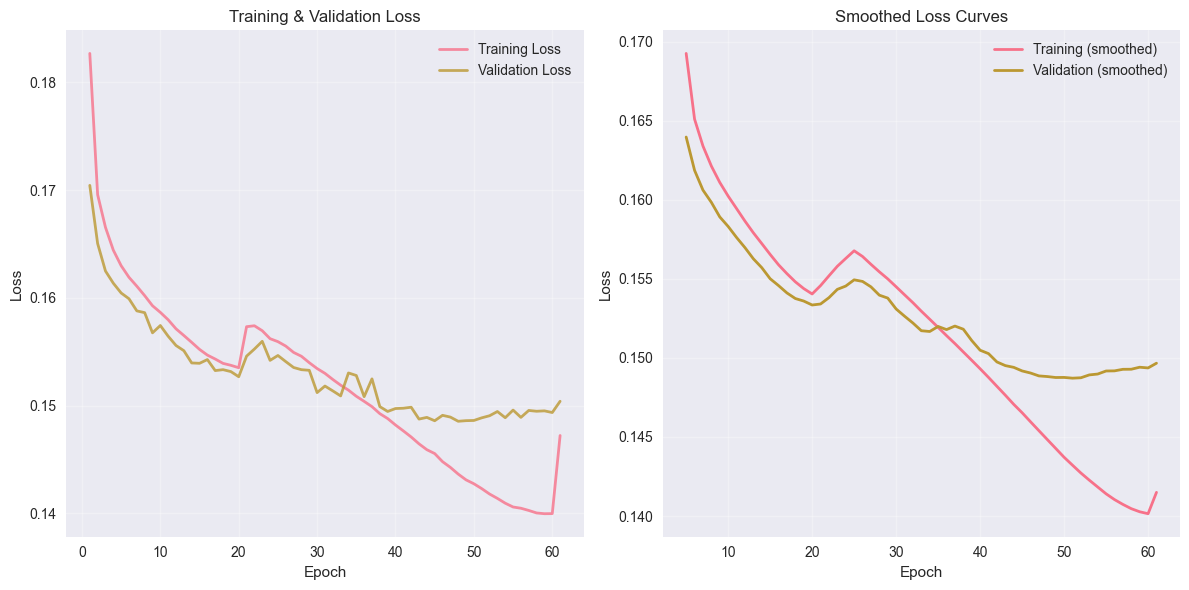

In [8]:
# Plot Loss Curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', linewidth=2, alpha=0.8)
plt.plot(epochs, val_loss, label='Validation Loss', linewidth=2, alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot smoothed version for better trend visualization
plt.subplot(1, 2, 2)
window_size = 5
if len(train_loss) >= window_size:
    train_smooth = np.convolve(train_loss, np.ones(window_size)/window_size, mode='valid')
    val_smooth = np.convolve(val_loss, np.ones(window_size)/window_size, mode='valid')
    smooth_epochs = epochs[window_size-1:]
    
    plt.plot(smooth_epochs, train_smooth, label=f'Training (smoothed)', linewidth=2)
    plt.plot(smooth_epochs, val_smooth, label=f'Validation (smoothed)', linewidth=2)
else:
    plt.plot(epochs, train_loss, label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, label='Validation Loss', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Smoothed Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Loss Component Analysis

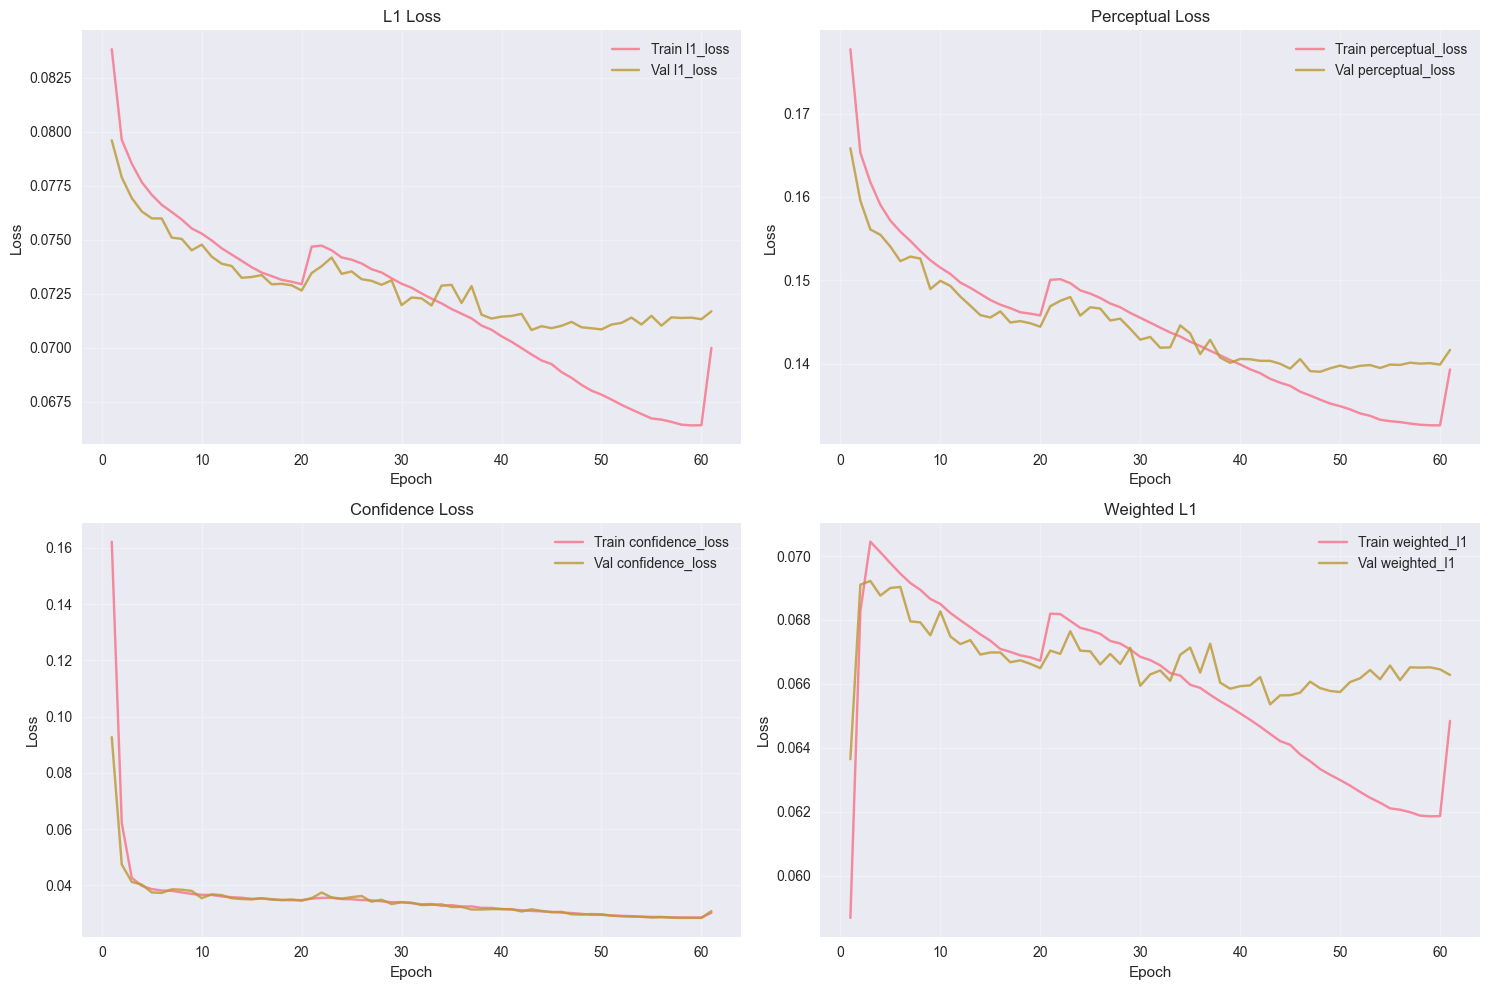

=== Final Loss Components ===
        l1_loss: Train=0.0700, Val=0.0717
perceptual_loss: Train=0.1393, Val=0.1416
confidence_loss: Train=0.0302, Val=0.0309
    weighted_l1: Train=0.0648, Val=0.0663


In [9]:
# Plot individual loss components if available
try:
    if 'train_components' in history and len(history['train_components']) > 0:
        # Extract component data
        components = ['l1_loss', 'perceptual_loss', 'confidence_loss', 'weighted_l1']
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, component in enumerate(components):
            train_component = [comp[component] for comp in history['train_components']]
            val_component = [comp[component] for comp in history['val_components']]
            
            axes[i].plot(epochs, train_component, label=f'Train {component}', alpha=0.8)
            axes[i].plot(epochs, val_component, label=f'Val {component}', alpha=0.8)
            axes[i].set_xlabel('Epoch')
            axes[i].set_ylabel('Loss')
            axes[i].set_title(f'{component.replace("_", " ").title()}')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Show final loss component values
        print("=== Final Loss Components ===")
        final_train = history['train_components'][-1]
        final_val = history['val_components'][-1]
        
        for component in components:
            print(f"{component:>15}: Train={final_train[component]:.4f}, Val={final_val[component]:.4f}")
    else:
        print("No component-wise loss data available")
        
except Exception as e:
    print(f"Error plotting loss components: {e}")

## Evaluation Metrics

=== Evaluation Metrics ===

RGB Image Quality Metrics:
          RGB_MAE: 0.0435
         RGB_PSNR: 24.8201
         RGB_SSIM: 0.9416

Color-Specific Metrics:
           AB_MAE: 0.0717
  Saturation_Diff: 0.0866

Model Metrics:
  Confidence_Mean: 0.8280

Other Info:
     Total_Images: 5000
       Checkpoint: best_model.pt


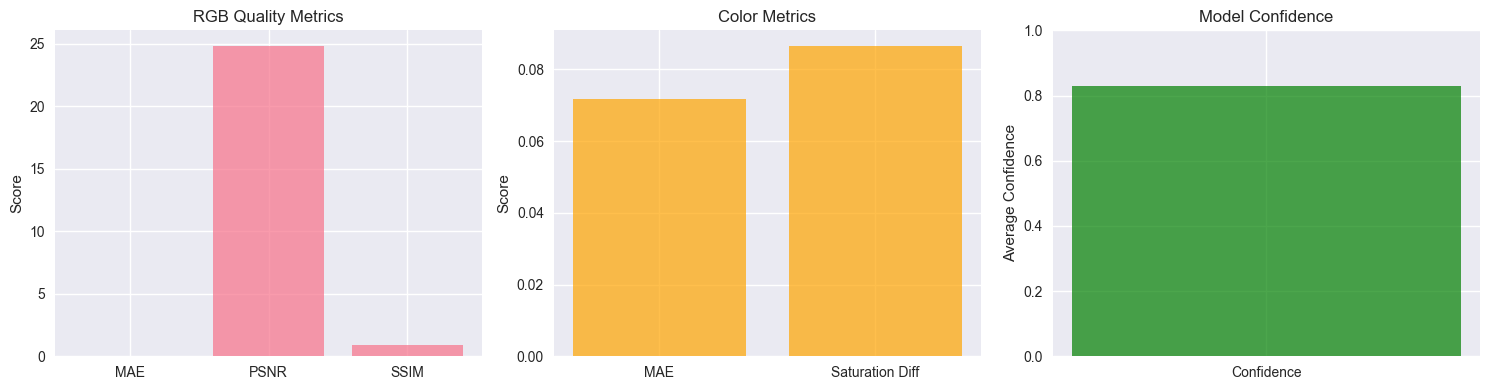

In [10]:
# Load and display evaluation metrics
try:
    with open(EVAL_METRICS_PATH, "r") as f:
        eval_metrics = json.load(f)

    print("=== Evaluation Metrics ===")
    
    # Group metrics by category
    rgb_metrics = {k: v for k, v in eval_metrics.items() if k.startswith('RGB_')}
    color_metrics = {k: v for k, v in eval_metrics.items() if k.startswith('AB_') or 'Saturation' in k}
    model_metrics = {k: v for k, v in eval_metrics.items() if 'Confidence' in k}
    other_metrics = {k: v for k, v in eval_metrics.items() 
                    if not any(k.startswith(prefix) for prefix in ['RGB_', 'AB_']) 
                    and 'Saturation' not in k and 'Confidence' not in k}
    
    print("\nRGB Image Quality Metrics:")
    for metric, value in rgb_metrics.items():
        print(f"  {metric:>15}: {value:.4f}")
    
    print("\nColor-Specific Metrics:")
    for metric, value in color_metrics.items():
        print(f"  {metric:>15}: {value:.4f}")
    
    print("\nModel Metrics:")
    for metric, value in model_metrics.items():
        print(f"  {metric:>15}: {value:.4f}")
    
    if other_metrics:
        print("\nOther Info:")
        for metric, value in other_metrics.items():
            print(f"  {metric:>15}: {value}")
            
    # Create a metrics visualization
    if rgb_metrics:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # RGB Metrics bar plot
        metric_names = [k.replace('RGB_', '') for k in rgb_metrics.keys()]
        metric_values = list(rgb_metrics.values())
        
        axes[0].bar(metric_names, metric_values, alpha=0.7)
        axes[0].set_title('RGB Quality Metrics')
        axes[0].set_ylabel('Score')
        
        # Color metrics
        if color_metrics:
            color_names = [k.replace('AB_', '').replace('_', ' ') for k in color_metrics.keys()]
            color_values = list(color_metrics.values())
            axes[1].bar(color_names, color_values, alpha=0.7, color='orange')
            axes[1].set_title('Color Metrics')
            axes[1].set_ylabel('Score')
        
        # Model confidence
        if model_metrics:
            conf_value = list(model_metrics.values())[0]
            axes[2].bar(['Confidence'], [conf_value], alpha=0.7, color='green')
            axes[2].set_title('Model Confidence')
            axes[2].set_ylabel('Average Confidence')
            axes[2].set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
        
except FileNotFoundError:
    print(f"Evaluation metrics file not found: {EVAL_METRICS_PATH}")
    print("Please run evaluation first: python evaluate.py")
except Exception as e:
    print(f"Error loading evaluation metrics: {e}")

## Model Predictions Visualization

In [ ]:
# Get sample images
try:
    all_test_files = [f for f in os.listdir(RGB_TEST_DIR) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    all_pred_files = [f for f in os.listdir(PRED_DIR) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Find files that have both ground truth and prediction
    common_files = list(set(all_test_files) & set(all_pred_files))
    
    print(f"Total test images: {len(all_test_files)}")
    print(f"Total predictions: {len(all_pred_files)}")
    print(f"Images with both GT and prediction: {len(common_files)}")
    
    if len(common_files) == 0:
        print("No matching prediction files found!")
        print("Please run evaluation first: python evaluate.py")
    else:
        # Sample files for display
        sample_files = random.sample(common_files, min(DISPLAY_N_IMAGES, len(common_files)))
        print(f"Displaying {len(sample_files)} sample predictions")
        
except Exception as e:
    print(f"Error accessing image directories: {e}")
    sample_files = []

Total test images: 5000
Total predictions: 5000
Images with both GT and prediction: 5000
Displaying 10 sample predictions


=== Model Predictions vs Ground Truth ===

Showing sample 1/10: Places365_test_00022207.jpg


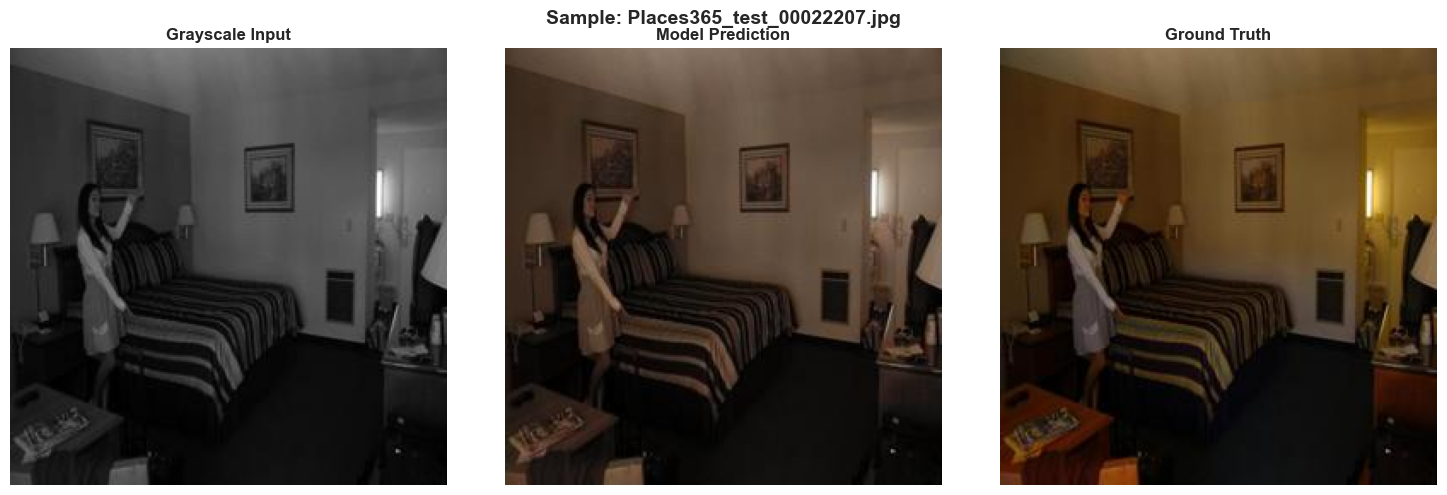


Showing sample 2/10: Places365_test_00023017.jpg


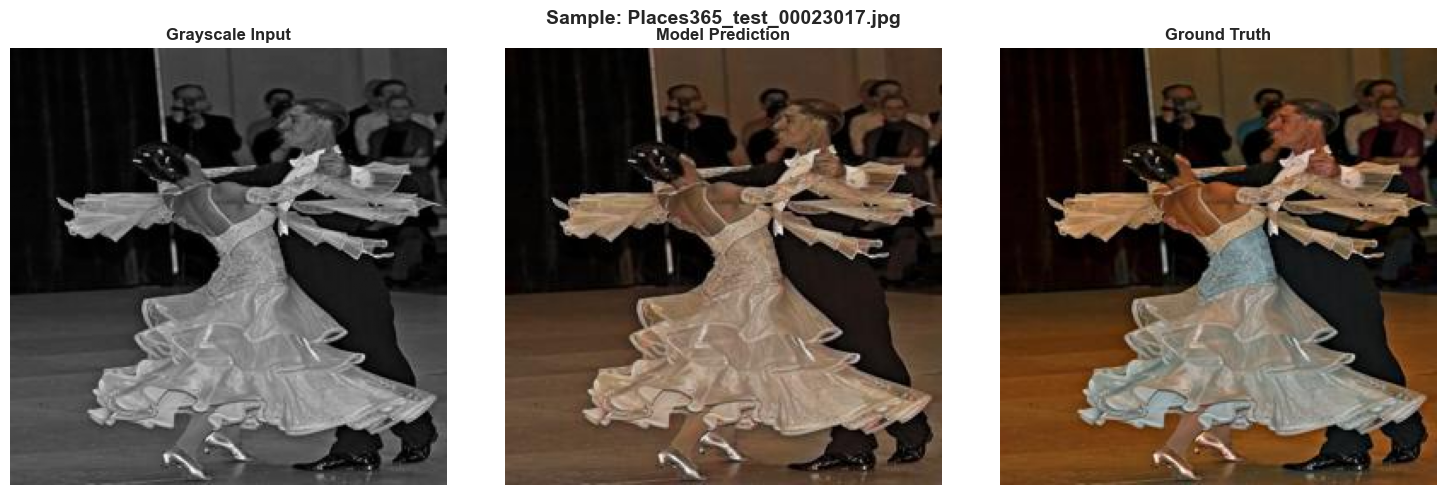


Showing sample 3/10: Places365_test_00024103.jpg


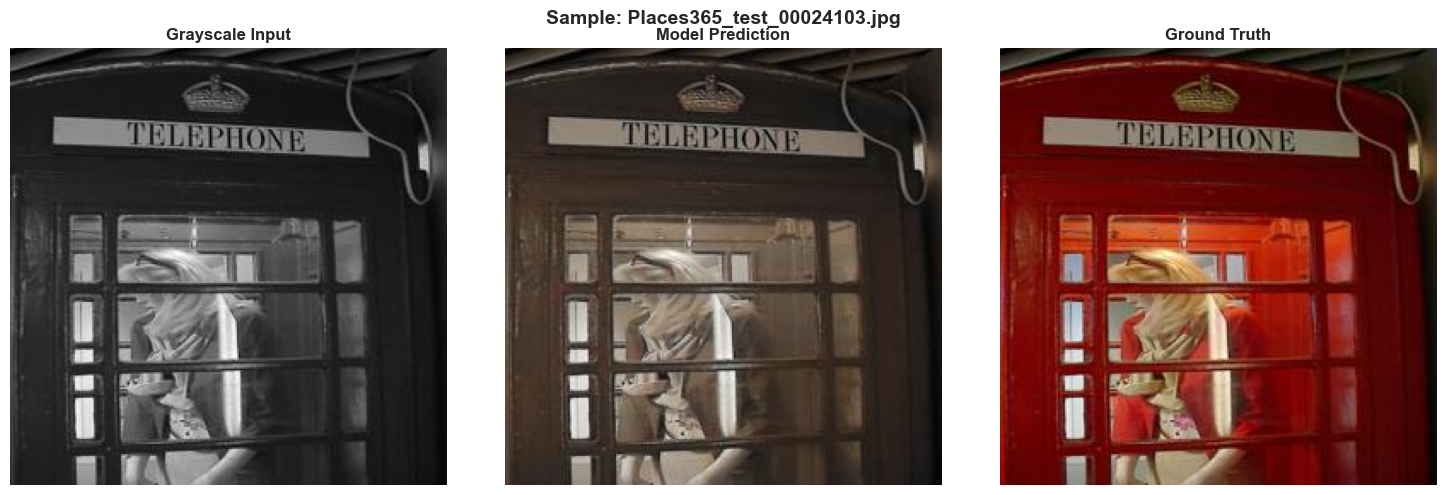


Showing sample 4/10: Places365_test_00194760.jpg


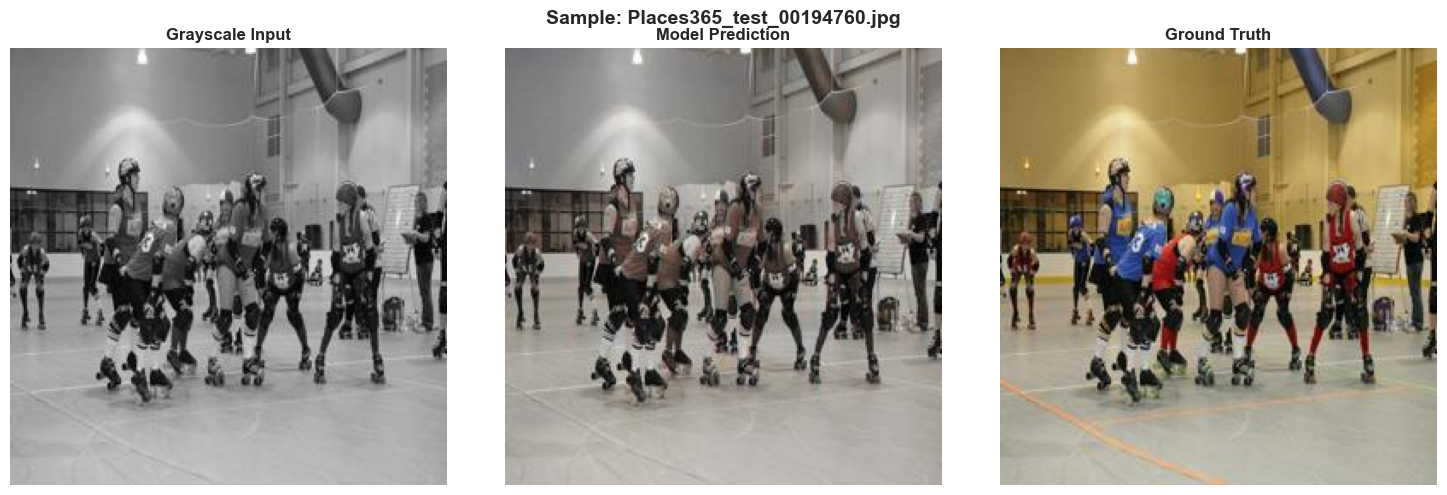


Showing sample 5/10: Places365_test_00042369.jpg


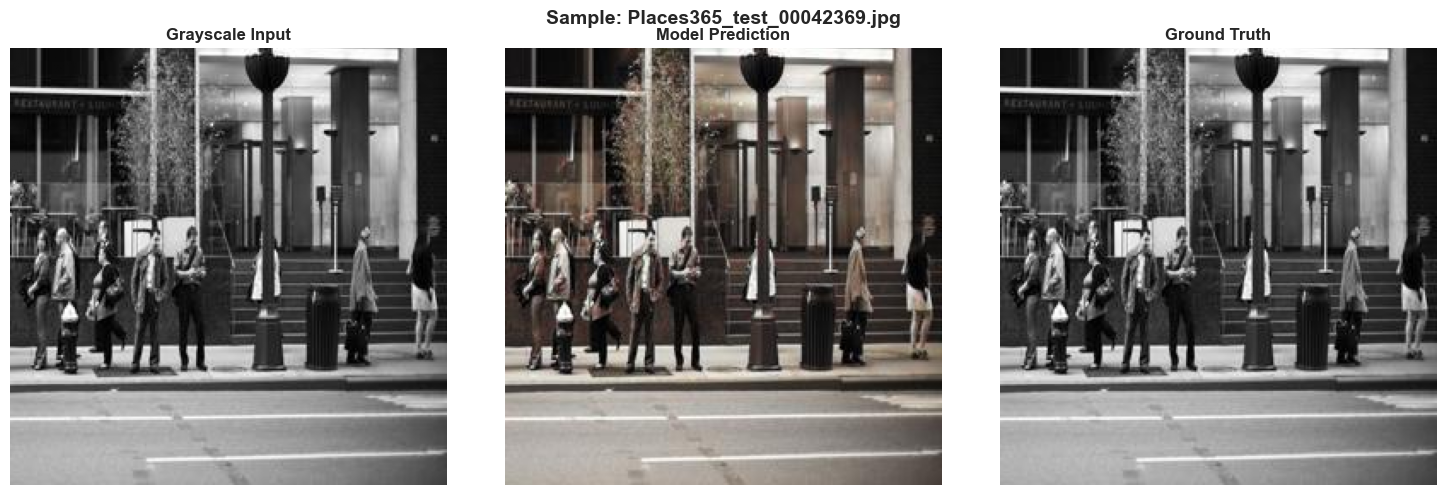


Showing sample 6/10: Places365_test_00215365.jpg


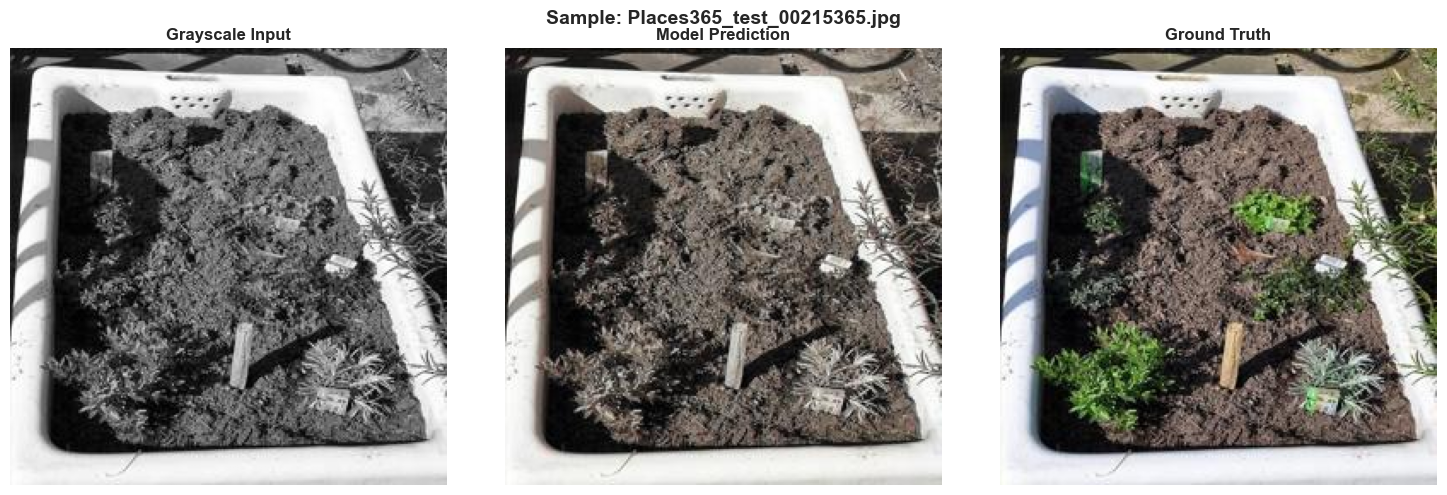


Showing sample 7/10: Places365_test_00159497.jpg


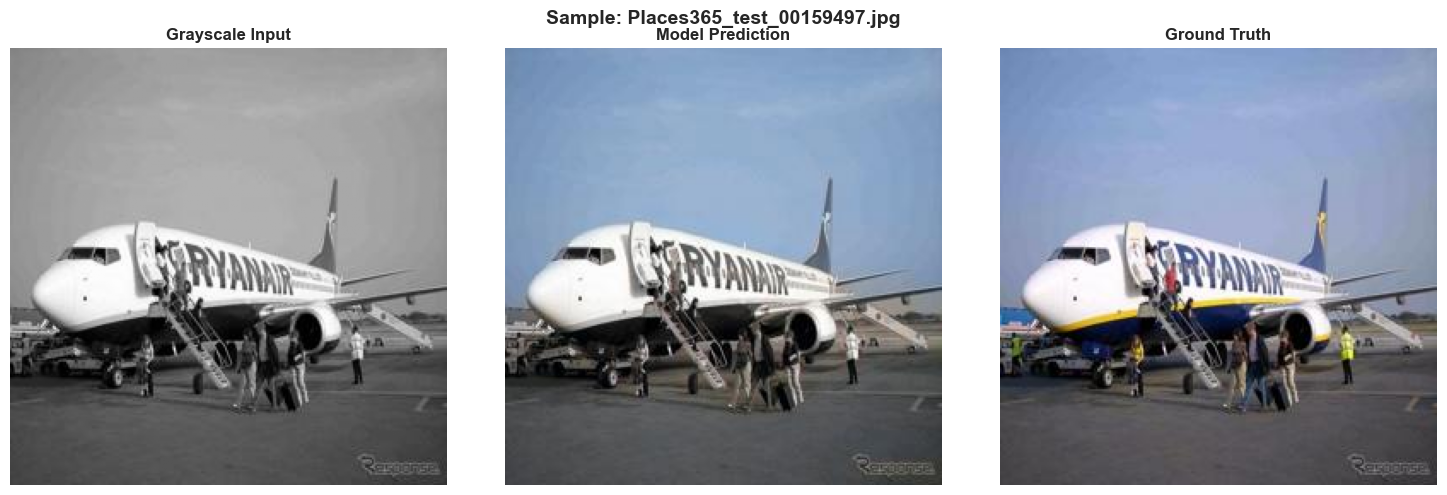


Showing sample 8/10: Places365_test_00174178.jpg


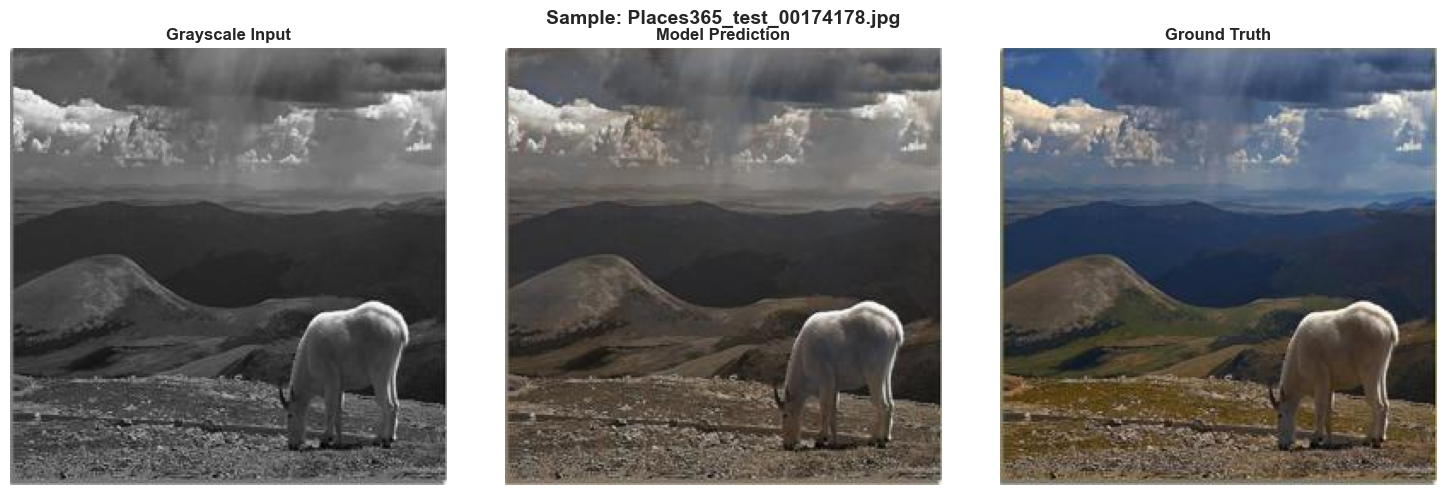


Showing sample 9/10: Places365_test_00136609.jpg


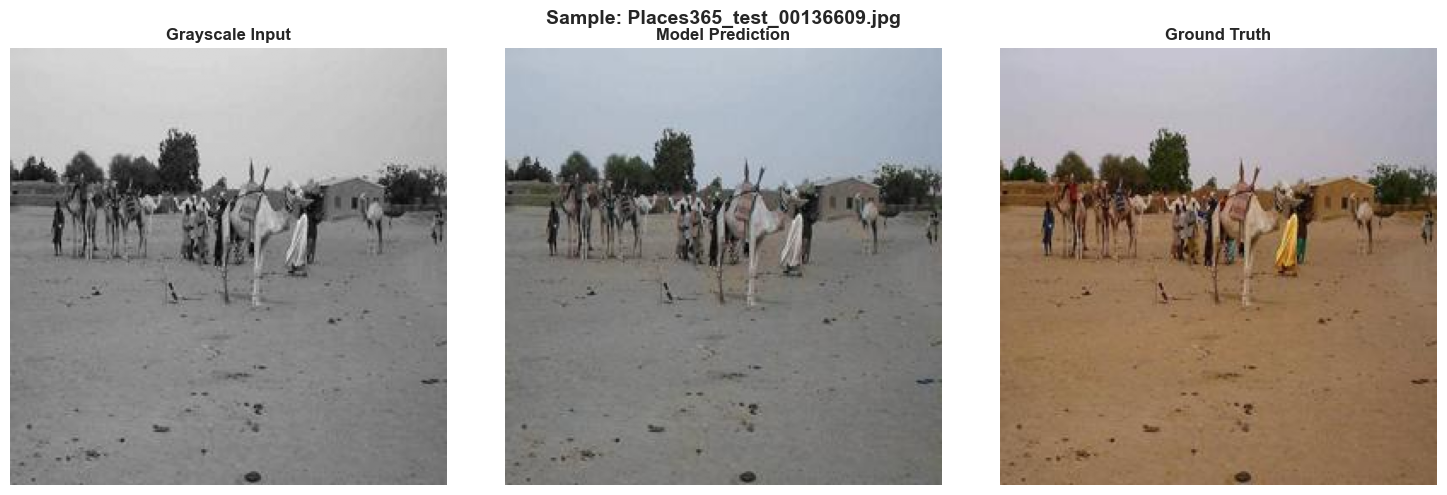


Showing sample 10/10: Places365_test_00269647.jpg


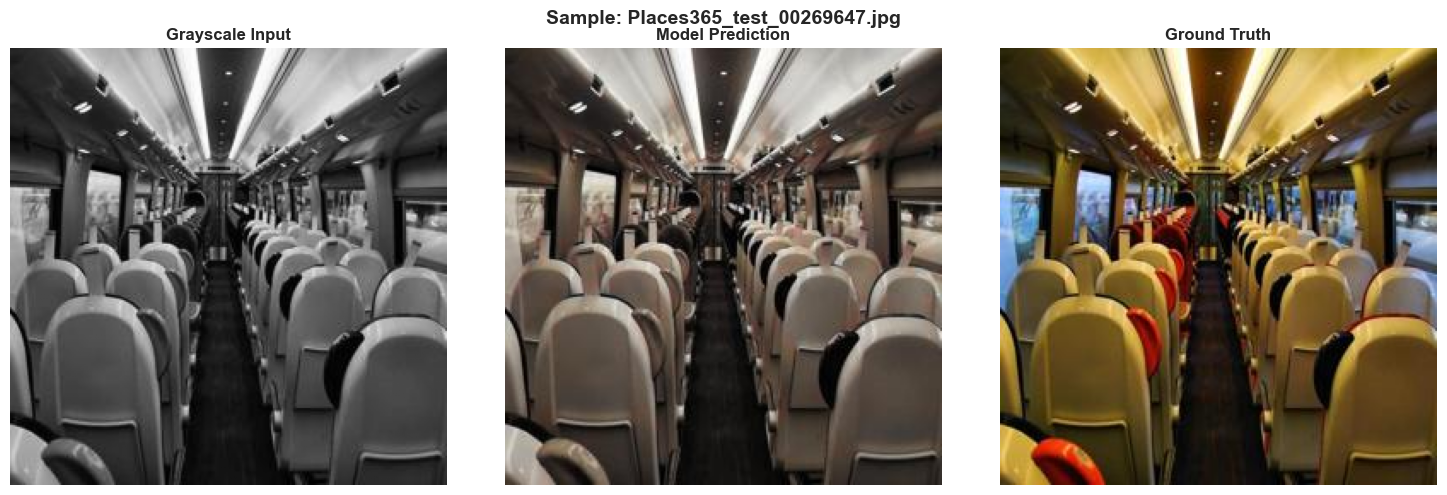

In [12]:
def show_comparison(rgb_path, pred_path, filename):
    """Show grayscale input, model prediction, and ground truth side by side"""
    try:
        # Load images
        rgb_img = Image.open(rgb_path).convert("RGB")
        gray_img = rgb_img.convert("L")
        pred_img = Image.open(pred_path).convert("RGB")
        
        # Create comparison plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Grayscale input
        axes[0].imshow(gray_img, cmap="gray")
        axes[0].set_title("Grayscale Input", fontsize=12, fontweight='bold')
        axes[0].axis("off")
        
        # Model prediction
        axes[1].imshow(pred_img)
        axes[1].set_title("Model Prediction", fontsize=12, fontweight='bold')
        axes[1].axis("off")
        
        # Ground truth
        axes[2].imshow(rgb_img)
        axes[2].set_title("Ground Truth", fontsize=12, fontweight='bold')
        axes[2].axis("off")
        
        plt.suptitle(f"Sample: {filename}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error displaying {filename}: {e}")

# Display sample comparisons
if 'sample_files' in locals() and len(sample_files) > 0:
    print("=== Model Predictions vs Ground Truth ===")
    
    for i, filename in enumerate(sample_files):
        print(f"\nShowing sample {i+1}/{len(sample_files)}: {filename}")
        
        rgb_path = os.path.join(RGB_TEST_DIR, filename)
        pred_path = os.path.join(PRED_DIR, filename)
        
        if os.path.exists(rgb_path) and os.path.exists(pred_path):
            show_comparison(rgb_path, pred_path, filename)
        else:
            print(f"❌ Missing files for {filename}")
            if not os.path.exists(rgb_path):
                print(f"   Missing: {rgb_path}")
            if not os.path.exists(pred_path):
                print(f"   Missing: {pred_path}")
else:
    print("No sample files available for display")